In [38]:
%matplotlib inline
import torch
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

Suppose that $h$, $w$ are the image's hight and width.

Let $s$ $\in$ (0,1) be the scale and $r>0$ be the aspect ration, then the width and the hight of the anchor box would be $ws\sqrt(r)$, $hs/\sqrt(r)$

Let us have a serie of scales $s_1, s_2, ..., s_n$ and a series or ratios $r_1, r_2, ..., r_m$, then we would have $n*m$ comibinations. However, that would be computationally expensive. So we will only consider those containing $s_1$ or $r_1$

In [4]:
def multibox_prior(data, sizes, ratios):
    """Generate anchor boxes with different shapes centered on each pixel."""
    in_height, in_width = data.shape[-2:]  # data is usually a feature map from CNN layer
    device, num_sizes, num_ratios = data.device, len(sizes), len(ratios)
    boxes_per_pixel = num_sizes + num_ratios - 1
    ratio_tensor = torch.tensor(ratios, device=device)
    size_tensor = torch.tensor(sizes, device=device)

    # Set offsets to 0.5 since the height and width of the pixel are 1
    offset_h, offset_w = 0.5, 0.5
    step_h = 1 / in_height  # Scaled step in y axis
    step_w = 1 / in_width  # Scaled step in x axis

    # Generate all center points for anchor boxes
    center_h = (torch.arange(in_height, device=device) + offset_h) * step_h
    center_w = (torch.arange(in_width, device=device) + offset_w) * step_w
    shift_y, shift_x = torch.meshgrid(center_h, center_w, indexing='ij')
    shift_y, shift_x = shift_y.reshape(-1), shift_x.reshape(-1)

    # Generate 'boxes_per_pixel' number of heights and widths
    w = torch.cat((size_tensor * torch.sqrt(ratio_tensor[0]),
                   sizes[0] * torch.sqrt(ratio_tensor[1:]))) * in_height / in_width
    h = torch.cat((size_tensor / torch.sqrt(ratio_tensor[0]),
                   sizes[0] / torch.sqrt(ratio_tensor[1:])))

    # Divide by 2 to get half height and half width
    anchor_manipulations = torch.stack((-w, -h, w, h)).T.repeat(in_height * in_width, 1) / 2

    # Each center point will have `boxes_per_pixel` number of anchor boxes
    out_grid = torch.stack([shift_x, shift_y, shift_x, shift_y], dim=1).repeat_interleave(boxes_per_pixel, dim=0)
    output = out_grid + anchor_manipulations
    return output.unsqueeze(0)

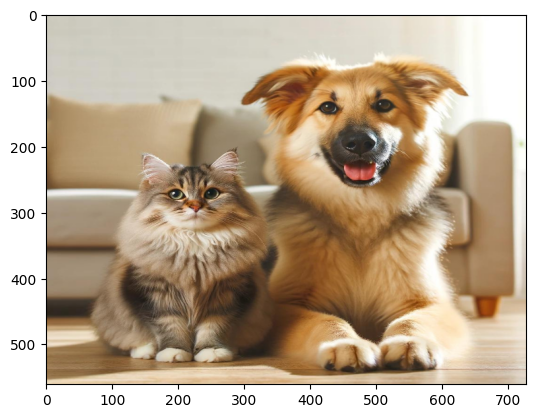

In [62]:
image_path = '../data/catdog.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (728, 561))
picture = plt.imshow(image)
plt.show()

In [63]:
h,w = image.shape[:2]
h,w

(561, 728)

In [64]:
X = torch.rand(size=(1, 3, h, w)) # Construct input Data
Y = multibox_prior(X, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5])
Y.shape

torch.Size([1, 2042040, 4])

In [65]:
# Reashape the anchor boxes to height, width , numberof anchor boxes, 4 
boxes = Y.reshape((h, w, 5, 4))

# Now, we can access each box with x, y coordinates
boxes[250, 250, 0,:] # first anchor box of the coordinates (250,250)

tensor([0.0551, 0.0715, 0.6331, 0.8215])

In [66]:
def show_bboxes(axes, bboxes, labels=None, colors=None):
    """Show bounding boxes."""
    def make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj
    
    labels = make_list(labels)
    colors = make_list(colors, ['b', 'g', 'r', 'm', 'c'])

    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1],
                                 linewidth=2, edgecolor=color, facecolor='none')
        axes.add_patch(rect)

        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i], 
                      va='center', ha='center', fontsize=9, color=text_color, 
                      bbox=dict(facecolor=color, lw=0))

In [67]:
def clip_boxes_to_image(boxes, image_shape):
    # Clip the bounding boxes to the borders of the image
    boxes[:, 0::2].clamp_(min=0, max=image_shape[1])  # Clamp x coordinates
    boxes[:, 1::2].clamp_(min=0, max=image_shape[0])  # Clamp y coordinates
    return boxes

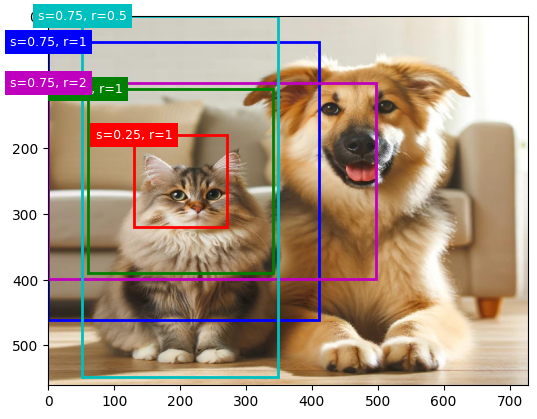

In [71]:
# Let us show the anchor boxes from position (250,200)
fig, axes = plt.subplots(1)
axes.imshow(image)
bbox_scale = torch.tensor((w, h, w, h))
show_bboxes(axes, clip_boxes_to_image(boxes[250,200,:,:] * bbox_scale, (h, w)), ['s=0.75, r=1', 's=0.5, r=1', 's=0.25, r=1', 's=0.75, r=2',
's=0.75, r=0.5'])
plt.show()